In [7]:
from IPython import get_ipython


# Segment Lights

In this notebook, the model the Christmas tree is calculated from a set of video recordings.

In [8]:
get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')
get_ipython().run_line_magic('matplotlib', 'inline')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


For each video, annotate the start time of the cycle

In [9]:
# Identify start and end of recording

import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob

from xmas_lights import find_flash_events, BulbDetector

videoPath = ['/notebooks/xmas_tree_videos/tree_calib_01.MP4',
             '/notebooks/xmas_tree_videos/tree_calib_02.MP4',
             '/notebooks/xmas_tree_videos/tree_calib_03.MP4',
             '/notebooks/xmas_tree_videos/tree_calib_04.MP4',
             '/notebooks/xmas_tree_videos/tree_calib_05.MP4']
time_range = [(4, 15), (7, 18), (1, 12), (6, 17), (7, 18)]
output_images = ['/notebooks/xmas_tree_videos/pics/tree_calib_01_%05d.jpg',
                 '/notebooks/xmas_tree_videos/pics/tree_calib_02_%05d.jpg',
                 '/notebooks/xmas_tree_videos/pics/tree_calib_03_%05d.jpg',
                 '/notebooks/xmas_tree_videos/pics/tree_calib_04_%05d.jpg',
                 '/notebooks/xmas_tree_videos/pics/tree_calib_05_%05d.jpg']



Find the location of each light in each video

In [10]:

def get_frame(cap, iframe):
    cap.set(cv2.CAP_PROP_POS_FRAMES, iframe)
    _, frame = cap.read()
    return frame

detector = BulbDetector()

imgpoints = []
imgs = []

for ipov in range(5):
    frame_event, frange_fine, _ = find_flash_events(videoPath[ipov], time_range[ipov])

    cap = cv2.VideoCapture(videoPath[ipov])

    frame = get_frame(cap, frange_fine[0])
    imgs.append(frame)

    imgp = []

    for iframe in frame_event[::1]:
        frame = get_frame(cap, iframe)

        img_point, area, _ = detector.detect(frame)
        imgp.append(img_point)
        # detector.plot(frame)

        if area > 0:
            center = tuple(np.round(img_point).astype(int))
            radius = np.round(np.sqrt(area / np.pi)).astype(int)
            frame = cv2.circle(frame, center, radius, (0, 0, 255), 3)

        cv2.imwrite(output_images[ipov] % (iframe), frame)

    imgpoints.append(np.reshape(imgp, (-1, 1, 2)))


Save results in a pickle file and plot

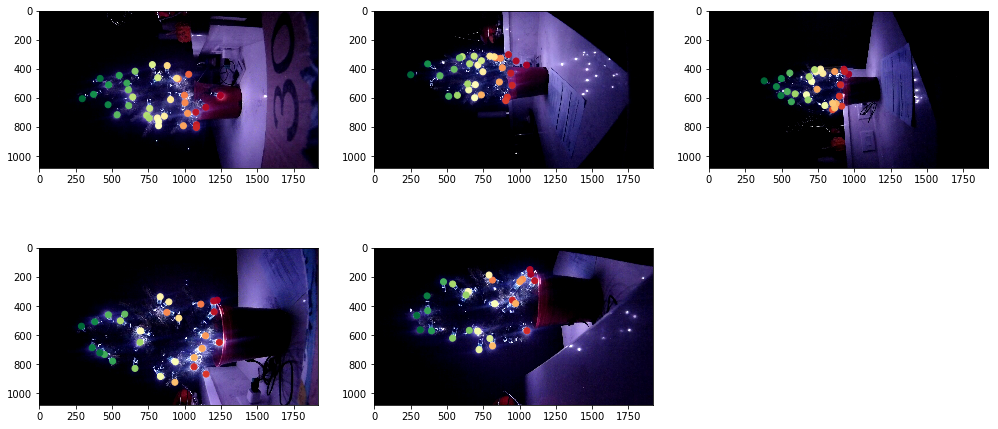

In [11]:
import pickle
from xmas_lights import plot_images

plot_images(imgs, imgpoints)

# Save calibration in file
dataset = {"imgpoints": imgpoints, "imgs": imgs}
outfile = open('tree_dataset.pickle', 'wb')
pickle.dump(dataset, outfile)
outfile.close()


This is how the flash events were identified

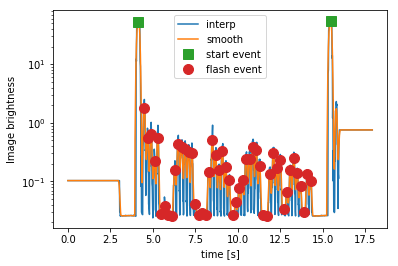

In [12]:
# Fine tune

frame_event, frange_fine, e = find_flash_events(videoPath[0], time_range[0])

plt.semilogy(e["time"], e["brights_interp"], '-')
plt.semilogy(e["time"], e["brights_smooth"], '-')
plt.semilogy(e["time"][frange_fine], e["brights_smooth"][frange_fine], 's', markersize=10)
plt.semilogy(frame_event/e["fps"], e["brights_smooth"][frame_event.astype(int)], 'o', markersize=10)
# plt.xlim((frange_fine[1] - 3, frange_fine[1] + 0.1))
plt.xlabel('time [s]'), plt.ylabel('Image brightness')
plt.legend(["interp", "smooth", "start event", "flash event"])
plt.show()



This was how the image threshold was determined 

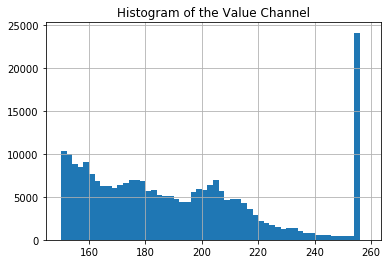

In [13]:
# Selecting the threshold value
frame = imgs[0]

# Select [V]alue channel
img = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
value = img[:,:,2]  # goes from 0 to 255

plt.hist(value.reshape(-1), bins=np.arange(150, 260, 2))
plt.title('Histogram of the Value Channel')
plt.grid()
plt.show()

thresh = 240
